In [4]:
import torch
import numpy as np
from networks.vision_transformer import SwinUnet as ViT_seg
from config import get_config
from networks.unet import UNet, UNet_DS, UNet_URPC, UNet_CCT
import segmentation_models_pytorch as smp

## Dermatomyositis

In [92]:
#CONSTANT
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_classes = 2
type_model = 'unet'
root_path = '/scratch/mc8895/SSL4SL/model/Dermatomyositis/Cross_Teaching_Between_CNN_Transformer_7/unet/'
best_model1_path = root_path+'model1_iter_9000.pth'
best_model2_path = root_path+'model2_iter_9000.pth'
patch_size = [480, 480]


In [93]:
# %ls /scratch/mc8895/SSL4SL/model/Dermatomyositis/Cross_Teaching_Between_CNN_Transformer_7

In [94]:
model1 = UNet(in_chns=1, class_num=num_classes).cuda()
model1.load_state_dict(torch.load(best_model1_path))


<All keys matched successfully>

In [95]:
from config import get_config
from argparse import Namespace

#initialiazed from parser args
args = Namespace(root_path='Dermatomyositis', exp='Dermatomyositis/Cross_Teaching_Between_CNN_Transformer', model='unet', max_iterations=10000, batch_size=16, deterministic=1, base_lr=0.01, patch_size=[480, 480], seed=1234, num_classes=2, cfg='../code/configs/swin_tiny_patch4_window7_224_lite.yaml', opts=None, zip=False, cache_mode='part', resume=None, accumulation_steps=None, use_checkpoint=True, amp_opt_level='O1', tag=None, eval=False, throughput=False, labeled_bs=8, labeled_num=7, ema_decay=0.99, consistency_type='mse', consistency=0.1, consistency_rampup=200.0)
config = get_config(args)
# config.defrost()
# config.MODEL.PRETRAIN_CKPT = best_model3_path
# print(config)
model2 = ViT_seg(config, img_size=args.patch_size, num_classes=args.num_classes).cuda()
# model2.load_from(config)

checkpoint  = torch.load(best_model2_path)
model2.load_state_dict(checkpoint)

=> merge config from ../code/configs/swin_tiny_patch4_window7_224_lite.yaml
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.2;num_classes:2
---final upsample expand_first---


<All keys matched successfully>

In [96]:
%ls ../../dataset/Dermatomyositis/tile_Image

'121919_Myo089_[10013,41652]_component_data_0.npy'
'121919_Myo089_[10013,41652]_component_data_1.npy'
'121919_Myo089_[10013,41652]_component_data_10.npy'
'121919_Myo089_[10013,41652]_component_data_11.npy'
'121919_Myo089_[10013,41652]_component_data_2.npy'
'121919_Myo089_[10013,41652]_component_data_3.npy'
'121919_Myo089_[10013,41652]_component_data_4.npy'
'121919_Myo089_[10013,41652]_component_data_5.npy'
'121919_Myo089_[10013,41652]_component_data_6.npy'
'121919_Myo089_[10013,41652]_component_data_7.npy'
'121919_Myo089_[10013,41652]_component_data_8.npy'
'121919_Myo089_[10013,41652]_component_data_9.npy'
'121919_Myo089_[10013,42350]_component_data_0.npy'
'121919_Myo089_[10013,42350]_component_data_1.npy'
'121919_Myo089_[10013,42350]_component_data_10.npy'
'121919_Myo089_[10013,42350]_component_data_11.npy'
'121919_Myo089_[10013,42350]_component_data_2.npy'
'121919_Myo089_[10013,42350]_component_data_3.npy'
'121919_Myo089_[10013,42350]_component_data_4.npy'
'121919_Myo089_[10013,42350

In [97]:
from dataloaders.dermofit_processing import build_dataloader_ssl

DATA_PATH = '../../dataset/Dermatomyositis/original_data/'
TILE_IMAGE_PATH = '../../dataset/Dermatomyositis/tile_Image/'
TILE_LABEL_PATH = '../../dataset/Dermatomyositis/tile_label/'

db_train, db_val, db_test = build_dataloader_ssl(DATA_PATH, TILE_IMAGE_PATH, TILE_LABEL_PATH, 2)

here in Dermatomyositis

train data: 1452
validation data: 720
test data: 204


In [91]:
'''
test performance
'''
tp_total=0
fp_total=0
fn_total=0
tn_total=0
for test_sample in db_test:
    inputs, mask = test_sample['image'], test_sample['label']
    inputs=inputs.to(device)
    mask=mask.to(device)
    outputs = model2(inputs.unsqueeze(0))
    model1.to(device)
    mask = mask.squeeze().to(device)
    pred = torch.argmax(outputs, dim=1)
    tp, fp, fn, tn = smp.metrics.get_stats(pred.squeeze(0), mask.long(), mode='multilabel', threshold=0.5)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
    tp_total+=tp
    fp_total+=fp
    fn_total+=fn
    tn_total+=tn
print('Overall Scores:')
iou_score = smp.metrics.iou_score(tp_total, fp_total, fn_total, tn_total, reduction="micro")
accuracy = smp.metrics.accuracy(tp_total, fp_total, fn_total, tn_total, reduction="macro")
print("Pixel Acc:",accuracy)
print("IoU:",iou_score)

Overall Scores:
Pixel Acc: tensor(0.9007, device='cuda:0')
IoU: tensor(6.4269e-07, device='cuda:0')


## visualization

In [62]:
i = np.random.randint(0, 100)
dict_sample = db_test[i]
inputs, mask = dict_sample['image'], dict_sample['label']
inputs = inputs.to(device)
mask = mask.to(device)
outputs = model1(inputs.unsqueeze(0))
print(f"input.shape: {inputs.shape}, mask.shape: {mask.shape}, output shape: {outputs.shape}") 

input.shape: torch.Size([1, 480, 480]), mask.shape: torch.Size([1, 480, 480]), output shape: torch.Size([1, 2, 480, 480])


In [98]:
img = np.load(TILE_IMAGE_PATH+'121919_Myo231_[9217,44122]_component_data_0.npy')
label = np.load(TILE_LABEL_PATH+'121919_Myo231_[9217,44122]_component_mask_0.npy')

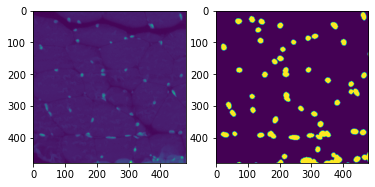

In [99]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(label)


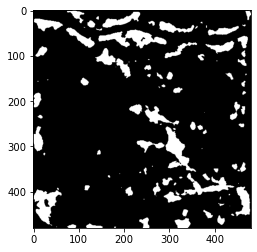

In [100]:
outputs = model1(torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device))
plt.imshow(torch.argmax(torch.softmax(outputs[0], dim = 0), dim=0).detach().cpu(), cmap='gray')


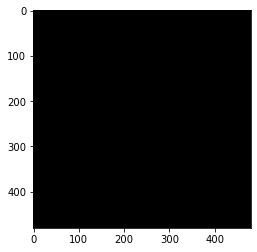

In [101]:
outputs = model2(torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device))
plt.imshow(torch.argmax(torch.softmax(outputs[0], dim = 0), dim=0).detach().cpu(), cmap='gray')


AttributeError: 'numpy.ndarray' object has no attribute 'permute'

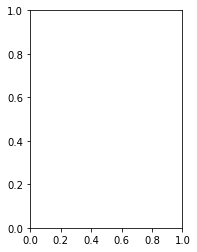

In [76]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(inputs.permute(1,2,0).detach().cpu())
plt.subplot(1,2,2)
plt.imshow(mask[0].detach().cpu())

In [64]:
# plt.subplot(1,2,1)
# plt.imshow(outputs[0][0].detach().cpu(), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(outputs[0][1].detach().cpu(),cmap='gray')

torch.Size([1, 2, 480, 480])


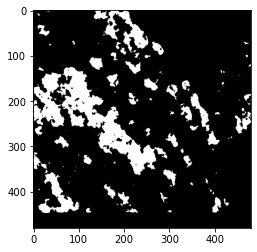

In [65]:
print(outputs.shape)
plt.imshow(torch.argmax(torch.softmax(outputs[0], dim = 0), dim=0).detach().cpu(), cmap='gray')

In [68]:
outputs = model2(inputs.unsqueeze(0))
# plt.subplot(1,2,1)
# plt.imshow(outputs[0][0].detach().cpu(), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(outputs[0][1].detach().cpu(),cmap='gray')

torch.Size([1, 2, 480, 480])


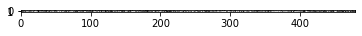

In [71]:
print(outputs.shape)
plt.imshow(torch.argmax(torch.softmax(outputs[0], dim = 0), dim=0).detach().cpu(), cmap='gray')

# Dermofit

In [17]:
num_classes = 2
type_model = 'unet'
best_model1_ssl_path = '/scratch/mc8895/SSL4SL/model/Dermofit/Cross_Teaching_CNN_Transformer_35/unet/unet_best_model1.pth'
best_model2_ssl_path = '/scratch/mc8895/SSL4SL/model/Dermofit/Cross_Teaching_CNN_Transformer_35/unet/unet_best_model2.pth'
# best_model2_full_path = '/scratch/mc8895/SSL4SL/model/Dermofit/Cross_Teaching_Between_CNN_Transformer_7/unet/unet_best_model2_dermofit_temp.pth'


patch_size = [480, 480]


In [18]:
from dataloaders.dermofit_processing import build_dataloader_ssl
DATA_PATH = '../../dataset/Dermofit/original_data/'
TILE_IMAGE_PATH = '../../dataset/Dermofit_resize_noTiling/resize_image/'
TILE_LABEL_PATH = '../../dataset/Dermofit_resize_noTiling/resize_label/'

db_train, db_val, db_test = build_dataloader_ssl(DATA_PATH, TILE_IMAGE_PATH, TILE_LABEL_PATH, True)

one_type = AK, total count of instances = 45
one_type = ALLSCC, total count of instances = 88
one_type = ALLMEL, total count of instances = 76
one_type = ALLBCC, total count of instances = 239
one_type = ALLSK, total count of instances = 257
one_type = ALLIEC, total count of instances = 78
one_type = ALLML, total count of instances = 331
one_type = ALLDF, total count of instances = 65
one_type = PYO, total count of instances = 24
one_type = ALLVASC, total count of instances = 97

train data: 1036
validation data: 130
test data: 134


In [19]:
model1_dermofit = UNet(in_chns=3, class_num=num_classes).cuda()
model1_dermofit.load_state_dict(torch.load(best_model1_ssl_path))


<All keys matched successfully>

In [20]:
from config import get_config
from argparse import Namespace

#initialiazed from parser args
args = Namespace(root_path='Dermofit', exp='Dermofit/Cross_Teaching_Between_CNN_Transformer', model='unet', max_iterations=10000, batch_size=16, deterministic=1, base_lr=0.01, patch_size=[480, 480], seed=1234, num_classes=2, cfg='../code/configs/swin_tiny_patch4_window7_224_lite.yaml', opts=None, zip=False, cache_mode='part', resume=None, accumulation_steps=None, use_checkpoint=True, amp_opt_level='O1', tag=None, eval=False, throughput=False, labeled_bs=8, labeled_num=7, ema_decay=0.99, consistency_type='mse', consistency=0.1, consistency_rampup=200.0)
config = get_config(args)
# config.defrost()
# config.MODEL.PRETRAIN_CKPT = best_model3_path
# print(config)
model2_dermofit_ssl = ViT_seg(config, img_size=args.patch_size, num_classes=args.num_classes).cuda()
# model2.load_from(config)

checkpoint  = torch.load(best_model2_ssl_path)
model2_dermofit_ssl.load_state_dict(checkpoint)


=> merge config from ../code/configs/swin_tiny_patch4_window7_224_lite.yaml
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.2;num_classes:2
---final upsample expand_first---


<All keys matched successfully>

In [21]:
i = np.random.randint(0, 1000)
dict_sample = db_train[i]
inputs, mask = dict_sample['image'], dict_sample['label']
inputs = inputs.to(device)
mask = mask.to(device)
outputs = model1_dermofit(inputs.unsqueeze(0))
print(f"input.shape: {inputs.shape}, mask.shape: {mask.shape}, output shape: {outputs.shape}") 


input.shape: torch.Size([3, 480, 480]), mask.shape: torch.Size([1, 480, 480]), output shape: torch.Size([1, 2, 480, 480])


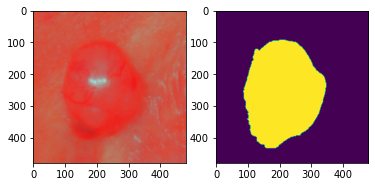

In [22]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(inputs.permute(1,2,0).detach().cpu())
plt.subplot(1,2,2)
plt.imshow(mask[0].detach().cpu())

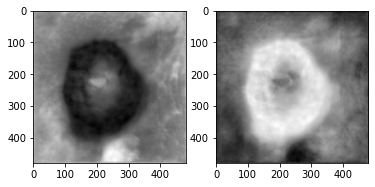

In [25]:
plt.subplot(1,2,1)
plt.imshow(outputs[0][0].detach().cpu(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(outputs[0][1].detach().cpu(),cmap='gray')

torch.Size([1, 2, 480, 480])


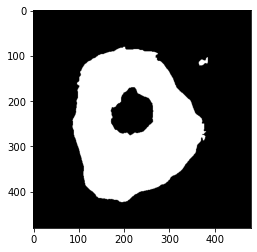

In [26]:
print(outputs.shape)
plt.imshow(torch.argmax(torch.softmax(outputs[0], dim = 0), dim=0).detach().cpu(), cmap='gray')

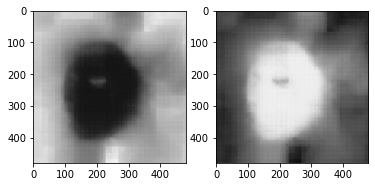

In [27]:
outputs = model2_dermofit_ssl(inputs.unsqueeze(0))
plt.subplot(1,2,1)
plt.imshow(outputs[0][0].detach().cpu(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(outputs[0][1].detach().cpu(),cmap='gray')

torch.Size([1, 2, 480, 480])


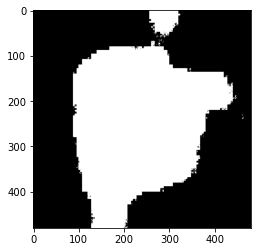

In [28]:
print(outputs.shape)
plt.imshow(torch.argmax(torch.softmax(outputs[0], dim = 0), dim=0).detach().cpu(), cmap='gray')

In [29]:
from config import get_config
from argparse import Namespace

#initialiazed from parser args
args = Namespace(root_path='Dermofit', exp='Dermofit/Cross_Teaching_Between_CNN_Transformer', model='unet', max_iterations=10000, batch_size=16, deterministic=1, base_lr=0.01, patch_size=[480, 480], seed=1234, num_classes=2, cfg='../code/configs/swin_tiny_patch4_window7_224_lite.yaml', opts=None, zip=False, cache_mode='part', resume=None, accumulation_steps=None, use_checkpoint=True, amp_opt_level='O1', tag=None, eval=False, throughput=False, labeled_bs=8, labeled_num=7, ema_decay=0.99, consistency_type='mse', consistency=0.1, consistency_rampup=200.0)
config = get_config(args)
model2_dermofit_fully = ViT_seg(config, img_size=args.patch_size, num_classes=args.num_classes).cuda()
checkpoint  = torch.load(best_model2_full_path)
model2_dermofit_fully.load_state_dict(checkpoint)


=> merge config from ../code/configs/swin_tiny_patch4_window7_224_lite.yaml
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.2;num_classes:2
---final upsample expand_first---


NameError: name 'best_model2_full_path' is not defined

In [ ]:
outputs = model2_dermofit_fully(inputs.unsqueeze(0))
plt.subplot(1,2,1)
plt.imshow(outputs[0][0].detach().cpu(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(outputs[0][1].detach().cpu(),cmap='gray')

In [ ]:
print(outputs.shape)
plt.imshow(torch.argmax(torch.softmax(outputs[0], dim = 0), dim=0).detach().cpu(), cmap='gray')